<a href="https://colab.research.google.com/github/dlskawns/coz-project/blob/main/CP2_%EA%B8%B0%ED%9A%8D_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/2019-Oct.csv')

In [4]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [ ]:
df.event_type.unique()

array(['view', 'purchase', 'cart'], dtype=object)

In [ ]:
df['date'] = pd.to_datetime(df['event_time'])

In [ ]:
df['date'][0]

Timestamp('2019-10-01 00:00:00+0000', tz='UTC')

In [ ]:
df['date'] = df['event_time'].map(lambda x: x[:10])

In [ ]:
# 일자 확인 -> 10-01 ~ 10-31 데이터
df['date'].unique()

array(['2019-10-01', '2019-10-02', '2019-10-03', '2019-10-04',
       '2019-10-05', '2019-10-06', '2019-10-07', '2019-10-08',
       '2019-10-09', '2019-10-10', '2019-10-11', '2019-10-12',
       '2019-10-13', '2019-10-14', '2019-10-15', '2019-10-16',
       '2019-10-17', '2019-10-18', '2019-10-19', '2019-10-20',
       '2019-10-21', '2019-10-22', '2019-10-23', '2019-10-24',
       '2019-10-25', '2019-10-26', '2019-10-27', '2019-10-28',
       '2019-10-29', '2019-10-30', '2019-10-31'], dtype=object)

In [ ]:
# 유저 수
len(df['user_id'].unique())

3022290

In [ ]:
# 상품 수
len(df['product_id'].unique())

166794

In [ ]:
# 카테고리 수
len(df['category_code'].unique())

127

In [ ]:
# 브랜드 수
len(df['brand'].unique())

3445

In [ ]:
df[df['user']=='purchase']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


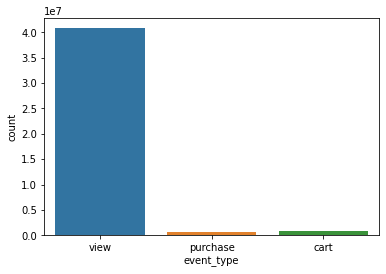

In [ ]:
import seaborn as sns

sns.countplot(df['event_type'])

In [ ]:
# purchase한 유저의 수
p_user = df[df['event_type']=='purchase']['user_id'].values
p_product = df[df['event_type']=='purchase']['product_id'].unique()

In [ ]:
purchased_df = df[(df['product_id'].isin(p_product))&(df['user_id'].isin(p_user))]

In [ ]:
purchased_df.groupby(['product_id','user_id'])['event_type'].count()

product_id  user_id  
1000978     512366656    1
            512399128    1
            512448158    1
            512457400    4
            512458113    3
                        ..
60500002    563964152    1
            564022246    1
            564294383    1
60500009    514446250    4
            529839452    1
Name: event_type, Length: 5125172, dtype: int64

In [ ]:
df[(df['product_id']==1000978)&(df['user_id']==543856131)]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
29058703,2019-10-21 18:11:12 UTC,view,1000978,2053013555631882655,electronics.smartphone,samsung,333.49,543856131,b040fde0-f103-4016-8cfd-9b1433b287ff
29060613,2019-10-21 18:12:34 UTC,view,1000978,2053013555631882655,electronics.smartphone,samsung,333.49,543856131,b040fde0-f103-4016-8cfd-9b1433b287ff
29061934,2019-10-21 18:13:29 UTC,purchase,1000978,2053013555631882655,electronics.smartphone,samsung,333.49,543856131,b040fde0-f103-4016-8cfd-9b1433b287ff
29062548,2019-10-21 18:13:54 UTC,view,1000978,2053013555631882655,electronics.smartphone,samsung,333.49,543856131,b040fde0-f103-4016-8cfd-9b1433b287ff
33629489,2019-10-25 06:37:50 UTC,view,1000978,2053013555631882655,electronics.smartphone,samsung,333.49,543856131,633ce9d4-a793-4cd9-ad10-ceb7de93f984
33630868,2019-10-25 06:38:52 UTC,purchase,1000978,2053013555631882655,electronics.smartphone,samsung,333.49,543856131,633ce9d4-a793-4cd9-ad10-ceb7de93f984
33631894,2019-10-25 06:39:37 UTC,view,1000978,2053013555631882655,electronics.smartphone,samsung,333.49,543856131,633ce9d4-a793-4cd9-ad10-ceb7de93f984


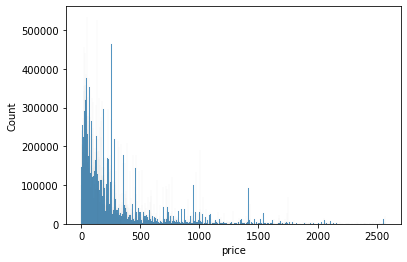

In [ ]:
sns.histplot(df['price'])
plt.show();

In [ ]:
# df['temp_vlookup'] = df['product_id'].astype(str) + df['user_id'].astype(str)


In [ ]:
re_order_count = df[df['event_type']=='purchase'].groupby(['product_id','user_id'])['event_type'].count()

In [ ]:

df = pd.merge(left=df, right=pd.DataFrame(re_order_count).reset_index(), how='left', \
                  on=['product_id','user_id'])

# df.join(pd.DataFrame(re_order_count), on = 'event_type')
# df.join(re_order_count, on = 'event_type')

In [ ]:
df.rename(columns = {'event_type_x': 'event_type', 'event_type_y':'reorder_cnt'}, inplace = True)

In [ ]:
df['reorder_cnt']

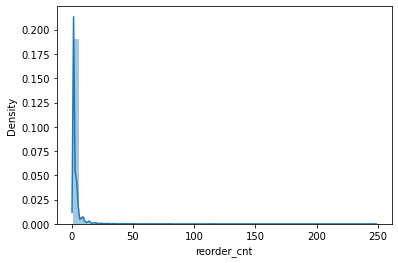

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 특정 상품에 대한 같은 월 내 구매 세션 수
sns.distplot(df['reorder_cnt'])
plt.show();

In [ ]:
# 구매를 한 적이 없는 사람 = reorder_cnt -> null인 고객 3천8백만
len(df[df['reorder_cnt'].isnull()])

38028564

In [ ]:
df[df['event_type']=='purchase']

In [ ]:
df.join(re_order_count.reset_index(), )

In [ ]:
len(df['user_session'].unique())

9244422

In [ ]:
for i in df['user_session'].unique():
  if len(df[df['user_session']==i]['product_id'].unique()) >1:
    print(df[df['user_session']==i]['product_id'].unique())

[17200506 15100337 15100008 15100367 15100034 15100220 15100214 15100288
 15100100]
[1307067 1306631 1306083 1307370 1306359]
[1004237 1005135]
[1480613 1480714 1480734 1480456 6700940]
[31500053 31501072 31501163]
[28719074 28719071]
[1004545 1801555 1801796]
[3900746 3900930]
[13500240 13500046 13500041 17200142 16800186 16800331 21405154 21403078]
[23100006 50500080]
[10900029  1004874  1004870]
[34700031 34700023]
[27500014 27500015  3701226]
[19001139 19000296 19000997 19000265 19002624 19002623 19001214]
[10800001 10800076 10800132 10800025 10800048  3300314]
[26200591 26201858]
[28714755 28708392 28715758 28715611 28717034 28704388]
[3701388 3701062 3700823 4600542]
[26200591 26201000 26201858 26400672]
[4300070 4300376 4300285]
[1004767 1004659]
[26500313 26500144 21403078 21402696]
[4100126 4100274 4100219 4100348]
[ 1005105 12709227  1005115]
[1307135 1307004]
[1005073 1004158]
[1004870 1004433 1004659 1004767]
[27700113 27701120 27700106]
[ 1004836 18000928  1005100]
[326010

In [ ]:
re_order_count = df[df['event_type']=='purchase'].groupby(['product_id','user_id'])['event_type'].count()
for i in range(len(re_order_count)):
  
# for i,j zip(re_order_count.index[0], re_order_count[1]):


MultiIndex([( 1000978, 517432921),
            ( 1000978, 518478766),
            ( 1000978, 532945616),
            ( 1000978, 543856131),
            ( 1000978, 547479795),
            ( 1000978, 559680841),
            ( 1000978, 560163787),
            ( 1000978, 561564140),
            ( 1000978, 564224920),
            ( 1000978, 565469756),
            ...
            (60400006, 512981817),
            (60500001, 531271515),
            (60500001, 553184946),
            (60500001, 555658150),
            (60500001, 558801181),
            (60500002, 513065871),
            (60500002, 517647881),
            (60500002, 526608637),
            (60500002, 556102277),
            (60500009, 514446250)],
           names=['product_id', 'user_id'], length=558484)

In [ ]:
for i in df[df['event_type']=='purchase']:
  df[df['product_id']==i['product_id']

['brand',
 'category_code',
 'category_id',
 'event_time',
 'event_type',
 'price',
 'product_id',
 'user_id',
 'user_session']

In [ ]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import dates


# datetime.strptime(df['date'][0], '%Y-%m-%d %H:%M:%S')

plt.figure()
plt.plot(df.groupby('date').sum()['price'], 'b.-')
plt.xticks(rotation=45)
ax = plt.gca()
ax.xaxis.set_major_locator(dates.MinuteLocator())

In [ ]:
import pandas as pd
import json

json_file_path = '/content/drive/MyDrive/스마트폰_로그_데이터셋.json'

with open(json_file_path, 'r') as j:
  json.loads(j.read())


JSONDecodeError: ignored

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/smartphon_1.csv')


,id,timestamp,utcoffset,subject_id,source_type,source_info,package_name,name,is_system_app,is_updated_system_app,type
0,4,1540790989686,9,2099efc17d719274924b8c81543c7972,PHONE,samsung-SM-G928S-7.0,com.nhn.android.band,BAND,0,0,USER_INTERACTION
1,7,1540790994228,9,2099efc17d719274924b8c81543c7972,PHONE,samsung-SM-G928S-7.0,com.nhn.android.band,BAND,0,0,MOVE_TO_FOREGROUND
2,10,1540790994420,9,2099efc17d719274924b8c81543c7972,PHONE,samsung-SM-G928S-7.0,com.nhn.android.band,BAND,0,0,MOVE_TO_BACKGROUND
3,13,1540790994486,9,2099efc17d719274924b8c81543c7972,PHONE,samsung-SM-G928S-7.0,com.nhn.android.band,BAND,0,0,MOVE_TO_FOREGROUND
4,16,1540791001635,9,2099efc17d719274924b8c81543c7972,PHONE,samsung-SM-G928S-7.0,com.nhn.android.band,BAND,0,0,MOVE_TO_BACKGROUND


In [ ]:
for i in range(33):
  print(len(df[df['subject_id']==df['subject_id'].unique()[i]]))

23242
47764
76989
57349
67326
29861
50692
24394
51539
129091
51969
39344
51421
33892
20516
682
26971
41334
72934
30124
16615
57593
24304
130600
25739
34508
76860
43688
63364
57133
27382
76904
26214


In [ ]:
df['type'].unique()

array(['USER_INTERACTION', 'MOVE_TO_FOREGROUND', 'MOVE_TO_BACKGROUND',
       'CONFIGURATION_CHANGE', 'NONE', 'SHORTCUT_INVOCATION'],
      dtype=object)

In [ ]:
df['name'].unique()

array(['BAND', '연락처', 'TouchWiz 홈', '삼성 인터넷', 'Google', '전화', 'Fitbit',
       'ABC Platform', '메시지', '알람/시간', '실행 중인 애플리케이션', 'Samsung Health',
       '네이버 카페', '카카오톡', 'Burgerking', '모아락', '캐시워크',
       'Samsung Experience 홈', '카메라', '안드로이드 시스템', 'L.POINT', '시스템 UI',
       '하이웍스', '하이웍스 메신저', 'Samsung Pay', '내 파일', 'Polaris Office', 'NFC',
       'LINE', '다운로드 관리자', 'PowerPoint', '설정', 'NAVER', 'CJ ONE', '코레일톡',
       'Gear S Plugin', 'SR 고속열차', 'Melon', 'T map', '카카오뱅크', 'Instagram',
       'KB스타뱅킹', 'KB스마트원 통합인증', 'Gmail', '마이\n홈플러스', '원터치알림', 'CLiP',
       '원터치개인', '시계', '위비멤버스', 'AhnLab V3 Mobile Plus 2.0', 'KB스타알림',
       '네이버TV', '날씨', 'Google Play 뮤직', 'Samsung Themes', '갤러리', '삼성 캡처',
       '네이버 사전', 'Google Play 스토어', '머큐리코리아', 'NS홈쇼핑', 'Chrome',
       'kt M모바일', 'KBO', '우리카드', '헤이카카오', '호텔스컴바인', '소프트웨어 업데이트',
       'SBS고릴라', 'AhnLab V3 Mobile Security', 'Coinstep',
       'CaptivePortalLogin', 'CGV', '업비트', '파인더', '음성 녹음', '후후', '네이버 지도',
       '똑똑가계부', '카카오스토리', '

In [ ]:
df[df['subject_id']==df['subject_id'].unique()[1]]

,id,timestamp,utcoffset,subject_id,source_type,source_info,package_name,name,is_system_app,is_updated_system_app,type
180,544,1540765803075,9,7c1a65e1496fc1e1702a8910e13be1b9,PHONE,samsung-SM-N910K-6.0.1,com.sec.android.app.clockpackage,알람/시간,1,0,MOVE_TO_FOREGROUND
181,547,1540765803086,9,7c1a65e1496fc1e1702a8910e13be1b9,PHONE,samsung-SM-N910K-6.0.1,com.sec.android.app.clockpackage,알람/시간,1,0,MOVE_TO_BACKGROUND
182,550,1540765805069,9,7c1a65e1496fc1e1702a8910e13be1b9,PHONE,samsung-SM-N910K-6.0.1,com.sec.android.app.clockpackage,알람/시간,1,0,MOVE_TO_FOREGROUND
183,553,1540765810494,9,7c1a65e1496fc1e1702a8910e13be1b9,PHONE,samsung-SM-N910K-6.0.1,com.sec.android.app.clockpackage,알람/시간,1,0,MOVE_TO_BACKGROUND
184,556,1540765810584,9,7c1a65e1496fc1e1702a8910e13be1b9,PHONE,samsung-SM-N910K-6.0.1,com.sec.android.app.taskmanager,실행 중인 애플리케이션,1,0,MOVE_TO_FOREGROUND
...,...,...,...,...,...,...,...,...,...,...,...
1086414,1105887,1540758799216,9,7c1a65e1496fc1e1702a8910e13be1b9,PHONE,samsung-SM-N910K-6.0.1,kvp.jjy.MispAndroid320,ISP/페이북,0,0,MOVE_TO_FOREGROUND
1086415,1105888,1540758799226,9,7c1a65e1496fc1e1702a8910e13be1b9,PHONE,samsung-SM-N910K-6.0.1,kvp.jjy.MispAndroid320,ISP/페이북,0,0,MOVE_TO_BACKGROUND
1086416,1105889,1540758799708,9,7c1a65e1496fc1e1702a8910e13be1b9,PHONE,samsung-SM-N910K-6.0.1,com.sec.android.app.taskmanager,실행 중인 애플리케이션,1,0,MOVE_TO_BACKGROUND
1086417,1105890,1540758799709,9,7c1a65e1496fc1e1702a8910e13be1b9,PHONE,samsung-SM-N910K-6.0.1,com.sec.android.app.taskmanager,실행 중인 애플리케이션,1,0,MOVE_TO_FOREGROUND


In [ ]:
df[df['subject_id']==df['subject_id'][0]]

,id,timestamp,utcoffset,subject_id,source_type,source_info,package_name,name,is_system_app,is_updated_system_app,type
0,4,1540790989686,9,2099efc17d719274924b8c81543c7972,PHONE,samsung-SM-G928S-7.0,com.nhn.android.band,BAND,0,0,USER_INTERACTION
1,7,1540790994228,9,2099efc17d719274924b8c81543c7972,PHONE,samsung-SM-G928S-7.0,com.nhn.android.band,BAND,0,0,MOVE_TO_FOREGROUND
2,10,1540790994420,9,2099efc17d719274924b8c81543c7972,PHONE,samsung-SM-G928S-7.0,com.nhn.android.band,BAND,0,0,MOVE_TO_BACKGROUND
3,13,1540790994486,9,2099efc17d719274924b8c81543c7972,PHONE,samsung-SM-G928S-7.0,com.nhn.android.band,BAND,0,0,MOVE_TO_FOREGROUND
4,16,1540791001635,9,2099efc17d719274924b8c81543c7972,PHONE,samsung-SM-G928S-7.0,com.nhn.android.band,BAND,0,0,MOVE_TO_BACKGROUND
...,...,...,...,...,...,...,...,...,...,...,...
826192,845665,1540789817283,9,2099efc17d719274924b8c81543c7972,PHONE,samsung-SM-G928S-7.0,com.nhn.android.band,BAND,0,0,MOVE_TO_FOREGROUND
826193,845666,1540789818740,9,2099efc17d719274924b8c81543c7972,PHONE,samsung-SM-G928S-7.0,com.nhn.android.band,BAND,0,0,MOVE_TO_BACKGROUND
826194,845667,1540789818804,9,2099efc17d719274924b8c81543c7972,PHONE,samsung-SM-G928S-7.0,com.samsung.android.contacts,연락처,1,0,MOVE_TO_FOREGROUND
826195,845668,1540789820013,9,2099efc17d719274924b8c81543c7972,PHONE,samsung-SM-G928S-7.0,com.fitbit.FitbitMobile,Fitbit,0,0,USER_INTERACTION


In [ ]:
with open('/content/drive/MyDrive/스마트폰_로그_데이터셋2.json', 'r') as json_file:
    json_data = json_file.read()
    # json_data = json.load(json_file)
    # utf_data = json_data.decode('utf-8')
    # ascii_data = json_data.encode('ascii', 'ignore')

In [ ]:
print(json_data[:100])

[
  {
    "timestamp": 1540790989686,
    "utcoffset": 9,
    "pid": "2099efc17d719274924b8c81543c79


In [ ]:
print(json_data[-100:])

 "package_name": "com.kakao.talk",
    "name": "카카오톡",
    "is_system_app": 0,
    "is_updated_syste


In [ ]:
a = '{"is_updated_syste"}'

print(a)

{"is_updated_syste"}


In [ ]:
json_data = json_data+

In [ ]:
# import io

# downloaded = io.BytesIO()
for i in range(1000):
  print(json_data[i])

In [ ]:
from pandas import json_normalize
df = json_normalize(json_data['timestamp']) #Results contain the required data
print(df)

TypeError: ignored

In [ ]:
type(json_data)

str